In [1]:
print('Loading.......')
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import cv2
import imutils
import numpy as np
from PIL import Image, ImageFilter
import math

Loading.......


In [2]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 4965 images belonging to 31 classes.
Found 907 images belonging to 31 classes.


In [3]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [4]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(31, activation='softmax'))

In [5]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=[custom_f1score])
model.summary()
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [6]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
            self.model.stop_training = True

In [7]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=[custom_f1score])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [8]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit(train_generator, steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, epochs = 8, verbose=1, callbacks=callbacks)

Epoch 1/8
4965/4965 [==============================] - 214s 43ms/step - loss: 1.0833 - custom_f1score: 0.7061 - val_loss: 0.6756 - val_custom_f1score: 0.8406
Epoch 2/8
4965/4965 [==============================] - 218s 44ms/step - loss: 0.4676 - custom_f1score: 0.8824 - val_loss: 0.4683 - val_custom_f1score: 0.8880
Epoch 3/8
4965/4965 [==============================] - 220s 44ms/step - loss: 0.3297 - custom_f1score: 0.9130 - val_loss: 0.2772 - val_custom_f1score: 0.9214
Epoch 4/8
4965/4965 [==============================] - 225s 45ms/step - loss: 0.2696 - custom_f1score: 0.9273 - val_loss: 0.3897 - val_custom_f1score: 0.8890
Epoch 5/8
4965/4965 [==============================] - 226s 45ms/step - loss: 0.2705 - custom_f1score: 0.9299 - val_loss: 0.2273 - val_custom_f1score: 0.9407
Epoch 6/8
4965/4965 [==============================] - 245s 49ms/step - loss: 0.4337 - custom_f1score: 0.8951 - val_loss: 1.7543 - val_custom_f1score: 0.4770
Epoch 7/8
4965/4965 [==============================]

In [9]:

# model.fit(train_generator, y_train, validation_data=(X_test, y_test), epochs=1)

In [10]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [11]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    ii = cv2.imread('contours.jpg')
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy)
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)
    return img_res

In [12]:
def segment_characters(image):
    img_lp = cv2.resize(image, (300, 95))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:10,:] = 255
    img_binary_lp[:,0:30] = 255
    img_binary_lp[93:95,:] = 255
    img_binary_lp[:,265:333] = 255
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contours.jpg',img_binary_lp)
    char_list = find_contours(dimensions, img_binary_lp)
    return char_list

0000_00532_b.jpg


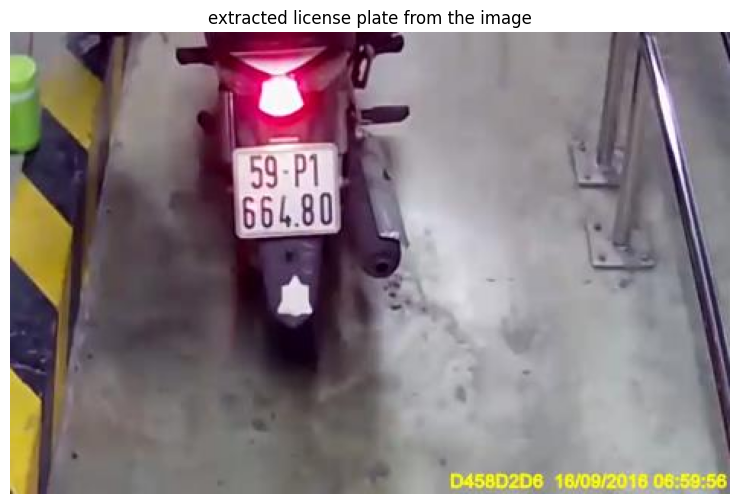

In [13]:
l=['0000_00532_b.jpg', '0000_02187_b.jpg', '0000_08244_b.jpg',
   '0002_02183_b.jpg', '0002_02554_b.jpg', '0003_02063_b.jpg',
   '0003_07398_b.jpg']
# for a in l:
a=l[0]
print(a)
plate=cv2.imread(a)
display(plate, 'extracted license plate from the image')

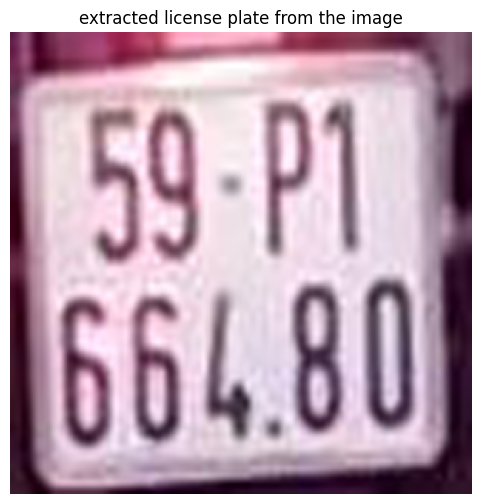

In [14]:
b='a'+a
Cropped=cv2.imread(b)
Cropped = cv2.resize(Cropped, (300, 300),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
cropped1=Cropped[0:160, 0:300]
cropped2=Cropped[140:300, 0:300]
cv2.imwrite('cropped1.jpg',cropped1)
cv2.imwrite('cropped2.jpg',cropped2)
display(Cropped, 'extracted license plate from the image')

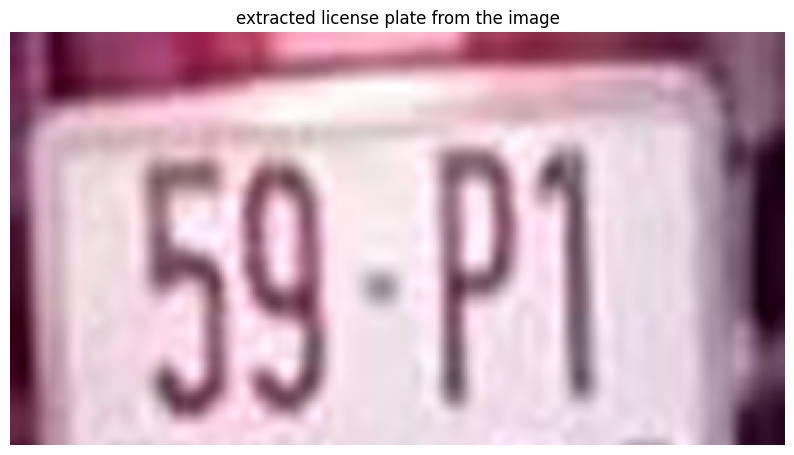

In [15]:
display(cropped1, 'extracted license plate from the image')

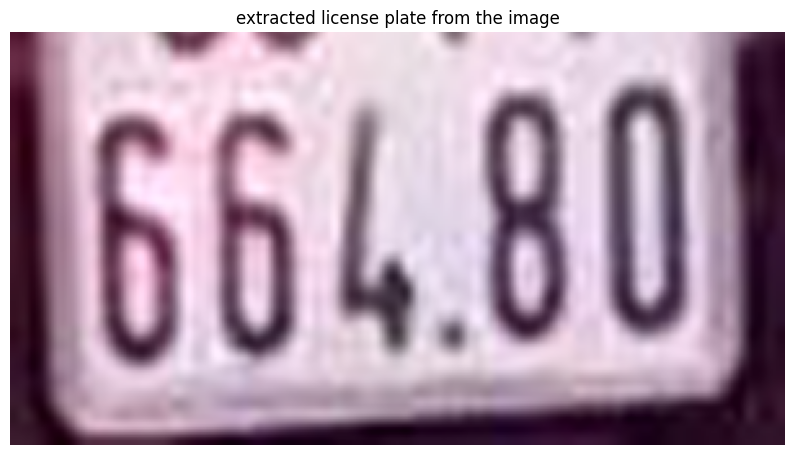

In [16]:
display(cropped2, 'extracted license plate from the image')

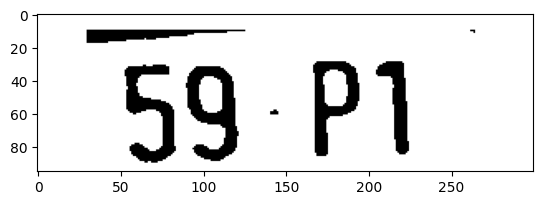

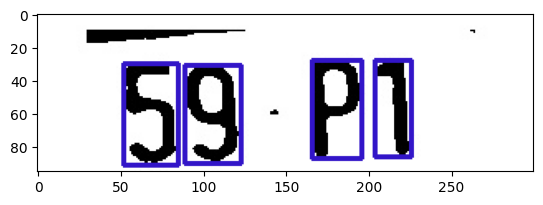

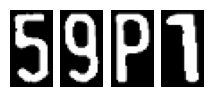

In [17]:
plate=cv2.imread('cropped1.jpg')
char1 = segment_characters(plate)
for i in range(4):
    plt.subplot(1, 10, i+1)
    plt.imshow(char1[i], cmap='gray')
    plt.axis('off')

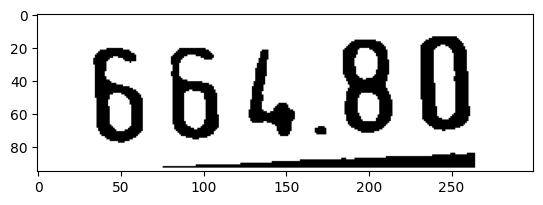

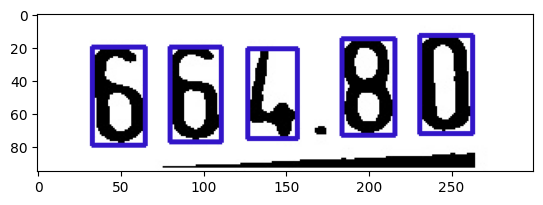

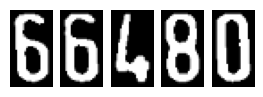

In [18]:
plate=cv2.imread('cropped2.jpg')
char2 = segment_characters(plate)
for i in range(5):
    plt.subplot(1, 10, i+1)
    plt.imshow(char2[i], cmap='gray')
    plt.axis('off')

In [19]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHKLMNPRSTUVXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict(img)
        y_ = np.argmax(y_, axis=1)
        x=y_[0]
        print(y_)
        output.append(characters[x]) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results(char1))
print(show_results(char2))

1/1 [==============================] - 0s 102ms/step
[5]
1/1 [==============================] - 0s 25ms/step
[9]
1/1 [==============================] - 0s 24ms/step
[22]
1/1 [==============================] - 0s 25ms/step
[1]
59P1
1/1 [==============================] - 0s 23ms/step
[6]
1/1 [==============================] - 0s 23ms/step
[6]
1/1 [==============================] - 0s 25ms/step
[4]
1/1 [==============================] - 0s 23ms/step
[8]
1/1 [==============================] - 0s 27ms/step
[0]
66480


1/1 [==============================] - 0s 26ms/step
[5]
1/1 [==============================] - 0s 23ms/step
[9]
1/1 [==============================] - 0s 27ms/step
[22]
1/1 [==============================] - 0s 24ms/step
[1]
1/1 [==============================] - 0s 27ms/step
[5]
1/1 [==============================] - 0s 25ms/step
[9]
1/1 [==============================] - 0s 24ms/step
[22]
1/1 [==============================] - 0s 29ms/step
[1]
1/1 [==============================] - 0s 24ms/step
[5]
1/1 [==============================] - 0s 26ms/step
[9]
1/1 [==============================] - 0s 22ms/step
[22]
1/1 [==============================] - 0s 27ms/step
[1]
1/1 [==============================] - 0s 23ms/step
[5]
1/1 [==============================] - 0s 25ms/step
[9]
1/1 [==============================] - 0s 23ms/step
[22]
1/1 [==============================] - 0s 25ms/step
[1]


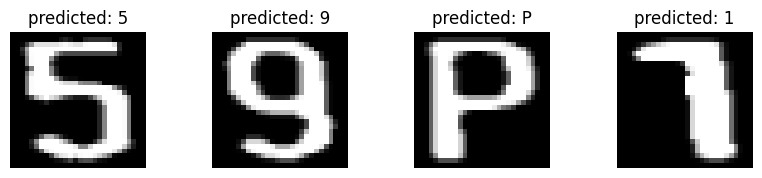

In [20]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char1):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(char1)[i]}')
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 24ms/step
[6]
1/1 [==============================] - 0s 23ms/step
[6]
1/1 [==============================] - 0s 27ms/step
[4]
1/1 [==============================] - 0s 25ms/step
[8]
1/1 [==============================] - 0s 25ms/step
[0]
1/1 [==============================] - 0s 27ms/step
[6]
1/1 [==============================] - 0s 32ms/step
[6]
1/1 [==============================] - 0s 24ms/step
[4]
1/1 [==============================] - 0s 27ms/step
[8]
1/1 [==============================] - 0s 25ms/step
[0]
1/1 [==============================] - 0s 26ms/step
[6]
1/1 [==============================] - 0s 28ms/step
[6]
1/1 [==============================] - 0s 24ms/step
[4]
1/1 [==============================] - 0s 26ms/step
[8]
1/1 [==============================] - 0s 27ms/step
[0]
1/1 [==============================] - 0s 24ms/step
[6]
1/1 [==============================] - 0s 24ms/step
[6]
1/1 [==============================] - 0s 24ms/s

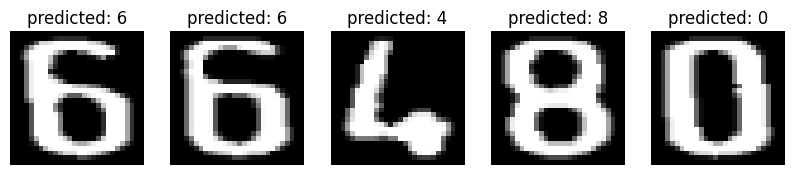

In [21]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char2):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,5,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(char2)[i]}')
    plt.axis('off')
plt.show()

In [22]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
    return plate_img, plate # returning the processed image.

In [23]:
plate_number = show_results(char1)+'-'+show_results(char2)
print(plate_number)

1/1 [==============================] - 0s 23ms/step
[5]
1/1 [==============================] - 0s 24ms/step
[9]
1/1 [==============================] - 0s 25ms/step
[22]
1/1 [==============================] - 0s 24ms/step
[1]
1/1 [==============================] - 0s 25ms/step
[6]
1/1 [==============================] - 0s 23ms/step
[6]
1/1 [==============================] - 0s 25ms/step
[4]
1/1 [==============================] - 0s 23ms/step
[8]
1/1 [==============================] - 0s 28ms/step
[0]
59P1-66480


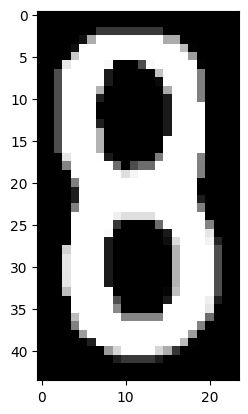

In [24]:
plt.imshow(char2[3], cmap='gray')

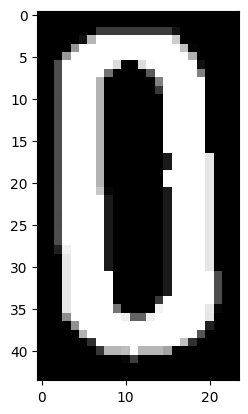

In [25]:
plt.imshow(char2[4], cmap='gray')

0000_00532_b.jpg


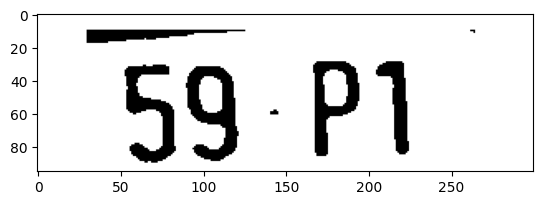

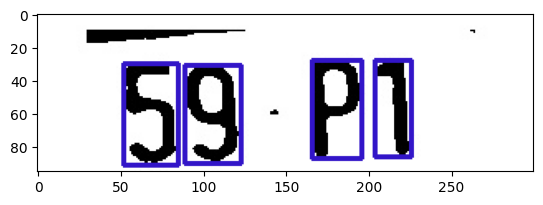

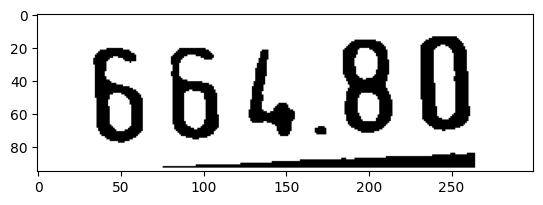

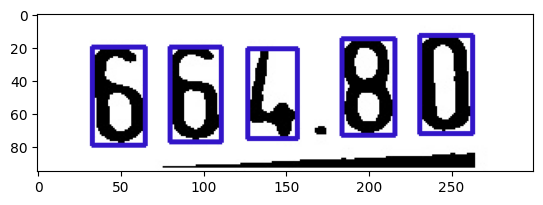

1/1 [==============================] - 0s 26ms/step
[5]
1/1 [==============================] - 0s 23ms/step
[9]
1/1 [==============================] - 0s 25ms/step
[22]
1/1 [==============================] - 0s 23ms/step
[1]
1/1 [==============================] - 0s 25ms/step
[6]
1/1 [==============================] - 0s 26ms/step
[6]
1/1 [==============================] - 0s 25ms/step
[4]
1/1 [==============================] - 0s 25ms/step
[8]
1/1 [==============================] - 0s 28ms/step
[0]
59P1-66480
0000_02187_b.jpg


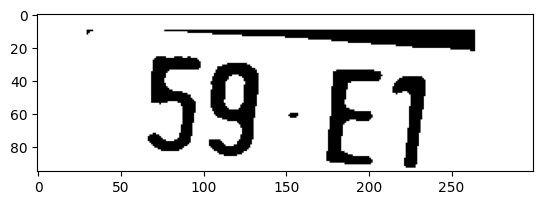

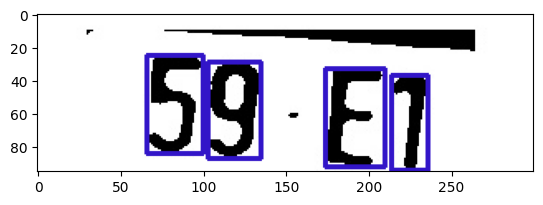

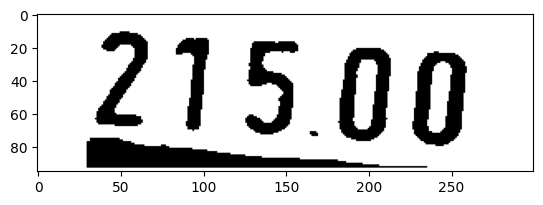

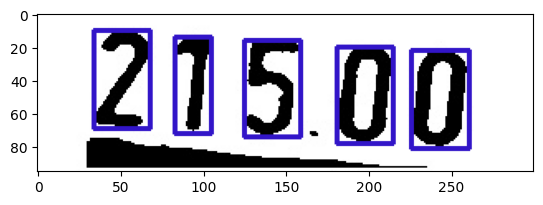

1/1 [==============================] - 0s 25ms/step
[5]
1/1 [==============================] - 0s 23ms/step
[9]
1/1 [==============================] - 0s 25ms/step
[8]
1/1 [==============================] - 0s 25ms/step
[7]
1/1 [==============================] - 0s 23ms/step
[2]
1/1 [==============================] - 0s 27ms/step
[7]
1/1 [==============================] - 0s 28ms/step
[5]
1/1 [==============================] - 0s 24ms/step
[0]
1/1 [==============================] - 0s 25ms/step
[0]
5987-27500
0000_08244_b.jpg


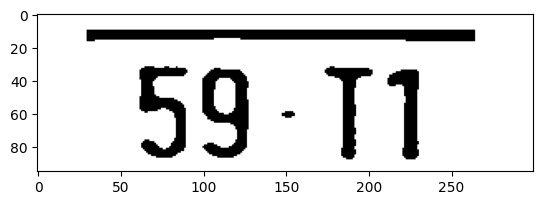

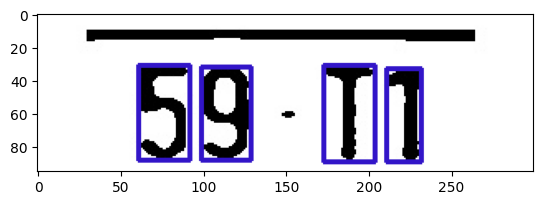

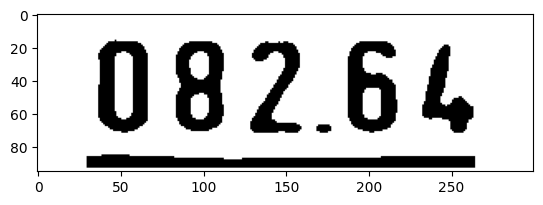

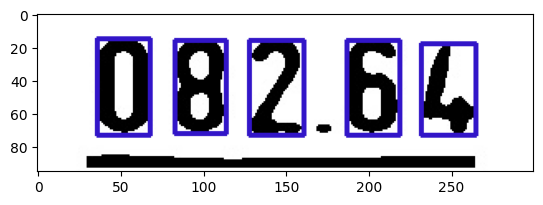

1/1 [==============================] - 0s 42ms/step
[5]
1/1 [==============================] - 0s 33ms/step
[9]
1/1 [==============================] - 0s 28ms/step
[25]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 25ms/step
[0]
1/1 [==============================] - 0s 26ms/step
[8]
1/1 [==============================] - 0s 26ms/step
[2]
1/1 [==============================] - 0s 24ms/step
[6]
1/1 [==============================] - 0s 26ms/step
[4]
59T1-08264
0002_02183_b.jpg


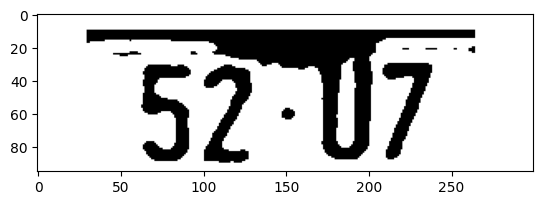

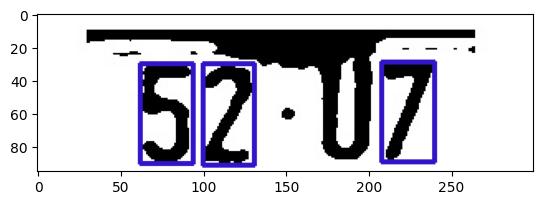

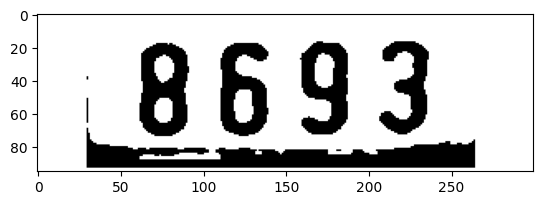

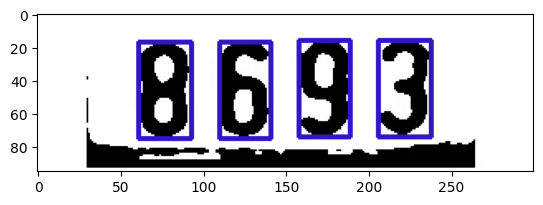

1/1 [==============================] - 0s 39ms/step
[5]
1/1 [==============================] - 0s 33ms/step
[2]
1/1 [==============================] - 0s 29ms/step
[7]
1/1 [==============================] - 0s 26ms/step
[8]
1/1 [==============================] - 0s 27ms/step
[6]
1/1 [==============================] - 0s 27ms/step
[9]
1/1 [==============================] - 0s 26ms/step
[3]
527-8693
0002_02554_b.jpg


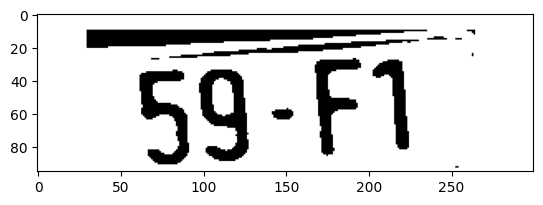

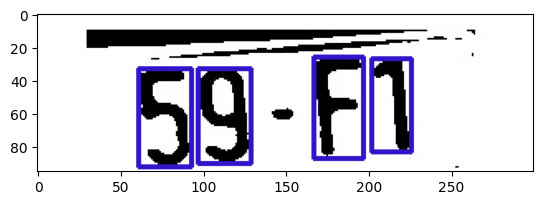

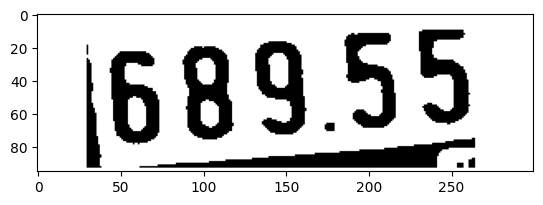

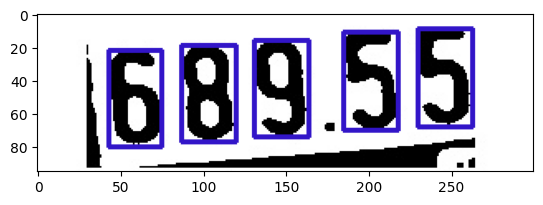

1/1 [==============================] - 0s 28ms/step
[5]
1/1 [==============================] - 0s 32ms/step
[9]
1/1 [==============================] - 0s 38ms/step
[15]
1/1 [==============================] - 0s 32ms/step
[1]
1/1 [==============================] - 0s 26ms/step
[6]
1/1 [==============================] - 0s 28ms/step
[8]
1/1 [==============================] - 0s 29ms/step
[9]
1/1 [==============================] - 0s 27ms/step
[5]
1/1 [==============================] - 0s 25ms/step
[5]
59F1-68955
0003_02063_b.jpg


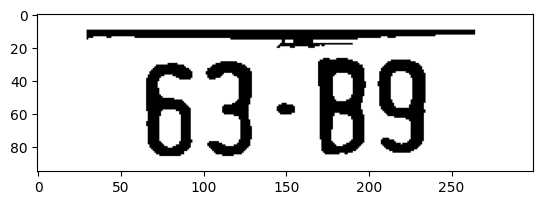

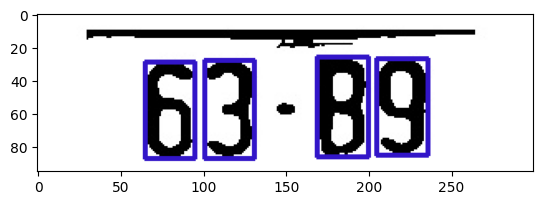

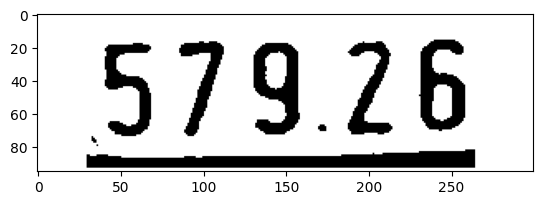

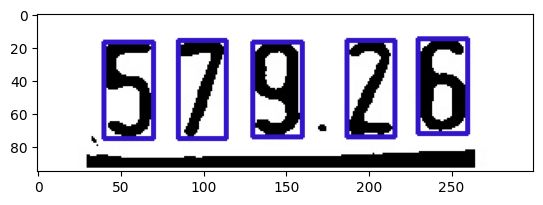

1/1 [==============================] - 0s 30ms/step
[6]
1/1 [==============================] - 0s 37ms/step
[3]
1/1 [==============================] - 0s 33ms/step
[8]
1/1 [==============================] - 0s 27ms/step
[9]
1/1 [==============================] - 0s 25ms/step
[5]
1/1 [==============================] - 0s 24ms/step
[7]
1/1 [==============================] - 0s 27ms/step
[9]
1/1 [==============================] - 0s 27ms/step
[2]
1/1 [==============================] - 0s 25ms/step
[6]
6389-57926
0003_07398_b.jpg


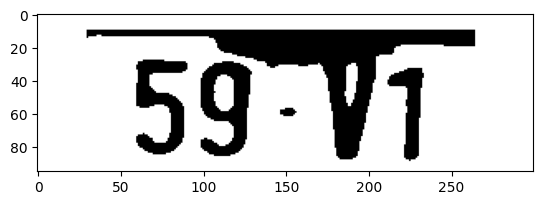

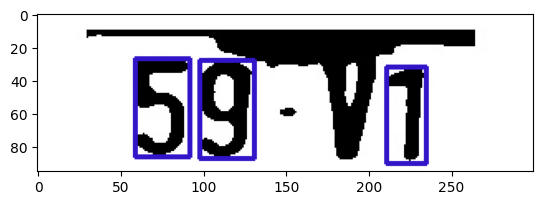

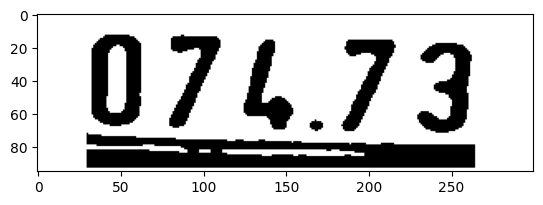

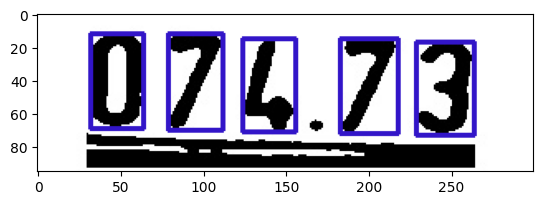

1/1 [==============================] - 0s 32ms/step
[5]
1/1 [==============================] - 0s 24ms/step
[9]
1/1 [==============================] - 0s 25ms/step
[1]
1/1 [==============================] - 0s 26ms/step
[0]
1/1 [==============================] - 0s 24ms/step
[7]
1/1 [==============================] - 0s 26ms/step
[4]
1/1 [==============================] - 0s 24ms/step
[7]
1/1 [==============================] - 0s 25ms/step
[3]
591-07473


In [26]:
l=['0000_00532_b.jpg', '0000_02187_b.jpg', '0000_08244_b.jpg',
   '0002_02183_b.jpg', '0002_02554_b.jpg', '0003_02063_b.jpg',
   '0003_07398_b.jpg']
A=[]
for a in l:
    print(a)
    b='a'+a
    Cropped=cv2.imread(b)
    Cropped = cv2.resize(Cropped, (300, 300),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
    y=0
    x=0
    h=300
    w=150
    cropped1=Cropped[0:160, 0:300]
    cropped2=Cropped[140:300, 0:300]
    cv2.imwrite('cropped1.jpg',cropped1)
    cv2.imwrite('cropped2.jpg',cropped2)
    plate=cv2.imread('cropped1.jpg')
    char1 = segment_characters(plate)
    plate=cv2.imread('cropped2.jpg')
    char2 = segment_characters(plate)
    plate_number = show_results(char1)+'-'+show_results(char2)
    A.append(plate_number)
    print(plate_number)

In [27]:
A

['59P1-66480',
 '5987-27500',
 '59T1-08264',
 '527-8693',
 '59F1-68955',
 '6389-57926',
 '591-07473']

In [28]:
import pandas as pd
data = pd.read_excel('data_test.xlsx')
data

,Biển số xe đã đăng ký,Mã sinh viên,Tên sinh viên,Số lượt
0,59P1-66480,201124029111,Mai A,0
1,59E1-21500,201124029112,Võ B,6
2,59T1-08264,201124029123,Phan C,8
3,59F1-68954,201124029145,Nguyễn D,15
4,63B9-57926,201124029555,Nguyễn F,9
5,59V1-07473,201124029414,Bùi G,19
6,52U7-8643,201124029132,Trần E,24


In [29]:
def Verification(plate_number):
    if plate_number in data['Biển số xe đã đăng ký'].unique():
        print('Mã sinh viên:',data[data['Biển số xe đã đăng ký']==plate_number]['Mã sinh viên'].unique()[0])
        x=input('Check mã sinh viên [y/n]?')
        if x=='y':
            if data[data['Biển số xe đã đăng ký']==plate_number]['Số lượt'].unique()[0]>0:
                data.loc[data['Biển số xe đã đăng ký']==plate_number,'Số lượt']=data[data['Biển số xe đã đăng ký']==plate_number]['Số lượt']-1
                print(data[data['Biển số xe đã đăng ký']==plate_number])
            else:
                print('Hết lượt!!!')
        else:
            print('Error!!!')
    else:
        print('Error!!!')

In [30]:
for i in range(7):
    print(A[i])
    Verification(A[i])
    print('\n')

59P1-66480
Mã sinh viên: 201124029111
Check mã sinh viên [y/n]?y
Hết lượt!!!


5987-27500
Error!!!


59T1-08264
Mã sinh viên: 201124029123
Check mã sinh viên [y/n]?y
  Biển số xe đã đăng ký  Mã sinh viên Tên sinh viên  Số lượt
2            59T1-08264  201124029123        Phan C        7


527-8693
Error!!!


59F1-68955
Error!!!


6389-57926
Error!!!


591-07473
Error!!!


